# Intraday Trading via Day Trading Techniques & Indicators
---

### Data collected via AlphaVantage free API using extended intraday data. 
> https://www.alphavantage.co/documentation/

---

# 04 - Modeling

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

# Read in Filtered Dataset

In [2]:
df = pd.read_csv('../01_Data/extended_intraday_SPY_1min_filtered.csv')

df['time'] = pd.DatetimeIndex(df['time'])
df.set_index(df['time'], inplace=True)
                              
df.drop(columns = ['time'], inplace = True)

**We also want to add our close_first_diff column for our time series models.**

In [3]:
df['close_first_diff'] = df['close'].diff()
df.head()

,open,high,low,close,volume,vwap,vwap_Distance,vwap_1std_above,vwap_1std_above_Distance,vwap_2std_above,...,9_EMA,9_EMA_Distance,20_EMA,20_EMA_Distance,EMA_Distance,EMA_cross,target,target_multi_class,target_binary_class,close_first_diff
time,,,,,,,,,,,,,,,,,,,,,
2019-10-28 09:00:00,292.963361,292.963361,292.944021,292.944021,4019,292.588294,0.355727,292.624673,0.319348,292.661051,...,292.862974,0.081047,292.760888,0.183133,0.102085,above,0.000000,flat,down,NaN
2019-10-28 09:01:00,292.944021,292.953691,292.905340,292.905340,8011,292.595649,0.309691,292.628422,0.276919,292.661194,...,292.871447,0.033894,292.774645,0.130695,0.096801,above,-0.013204,down,down,-0.03868
2019-10-28 09:02:00,292.924681,292.924681,292.915011,292.915011,5268,292.600448,0.314563,292.630436,0.284574,292.660424,...,292.880160,0.034851,292.788014,0.126997,0.092146,above,0.003301,flat,up,0.00967
2019-10-28 09:03:00,292.905340,292.905340,292.895670,292.905340,660,292.601021,0.304320,292.628609,0.276731,292.656198,...,292.885196,0.020145,292.799188,0.106153,0.086008,above,-0.003301,flat,down,-0.00967
2019-10-28 09:04:00,292.915011,292.915011,292.895670,292.895670,2709,292.603276,0.292395,292.628085,0.267585,292.652895,...,292.887291,0.008380,292.808376,0.087294,0.078914,above,-0.003301,flat,down,-0.00967


In [4]:
df.shape

(223009, 29)

In [5]:
df.dropna(inplace=True)

# Null Model

**There is a common saying among stock market folk,**
>"The market tends to go up." 

**Let's see if thats true.**

In [6]:
df['target_binary_class'].value_counts(normalize=True)

down    0.511641
up      0.488359
Name: target_binary_class, dtype: float64

According to our dataset, the SPY on 1 minute intervals
- goes DOWN 51.1% of the time
- goes UP 48.9% of the time

---
**This result is a bit misleading.** 

We observe through this line of code that, on average, prices go down 51.1% of the time and go up only 48.9% of the time. However, when the target variable was made for binary classification, only values > 0 were counted as 'up', while <= 0 were labeled as 'down'. 
>When incorporating that flat movements are counted towards 'down', we are more willing to believe the split in our target column as slightly favoring 'down'.

### Our Null model for Binary Classification is 51.1% accurate (guessing majority class for all; DOWN)
---

**We split our target into 3 classes in order to separate and analyze this further.**

In [7]:
df['target_multi_class'].value_counts(normalize=True)

flat    0.359794
up      0.323961
down    0.316244
Name: target_multi_class, dtype: float64

**Now we see why our binary classification was not following common opinion.**

According to our dataset, the SPY on 1 minute intervals:
- is FLAT 35.9797% of the time
- goes UP 32.3960% of the time
- goes DOWN 31.6243% of the time
> Looking back to the surprise of 'down' being our majority class above, we see why when a portion of 'flat' was added to 'down', it became our most populated class for binary classification.

### Our Null model for MultiClass(3) Classification is 35.9797% accurate (guessing majority class for all; FLAT)
### HOWEVER, when looking for a model that is useful to us, we still want a model at least 50% accurate.
---

# Simple Linear Model

To learn more about our dataset before diving into Time Series models, let's fit a Linear Model and observe the results.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['target', 'target_binary_class', 
                                                                       'target_multi_class', 'EMA_cross']), 
                                                    df['target'],                                                     
                                                    test_size = 0.2, 
                                                    shuffle=False
                                                   )

In [9]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

In [10]:
lm = sm.OLS(y_train, X_train)

In [11]:
lm_results = lm.fit()

In [12]:
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 2.478e+05
Date:                Mon, 25 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:04:44   Log-Likelihood:             4.8776e+05
No. Observations:              178406   AIC:                        -9.755e+05
Df Residuals:                  178395   BIC:                        -9.754e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

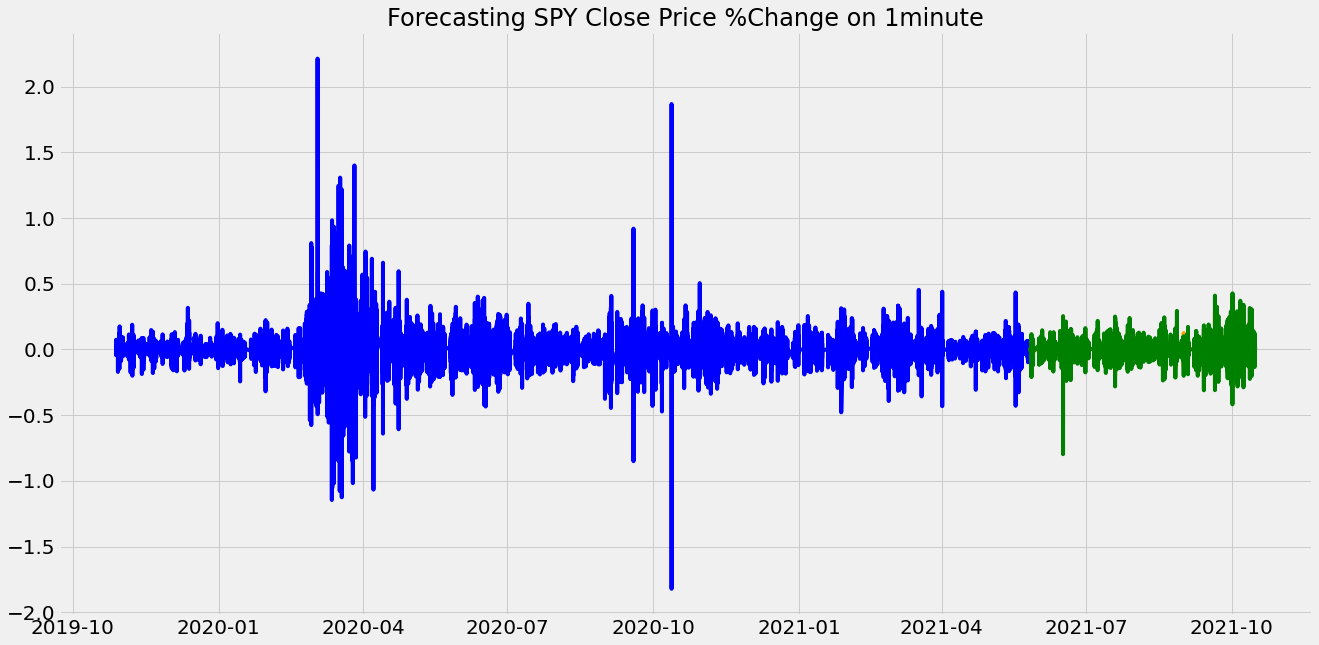

In [13]:
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green')

# Set label.
plt.title(label = 'Forecasting SPY Close Price %Change on 1minute', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

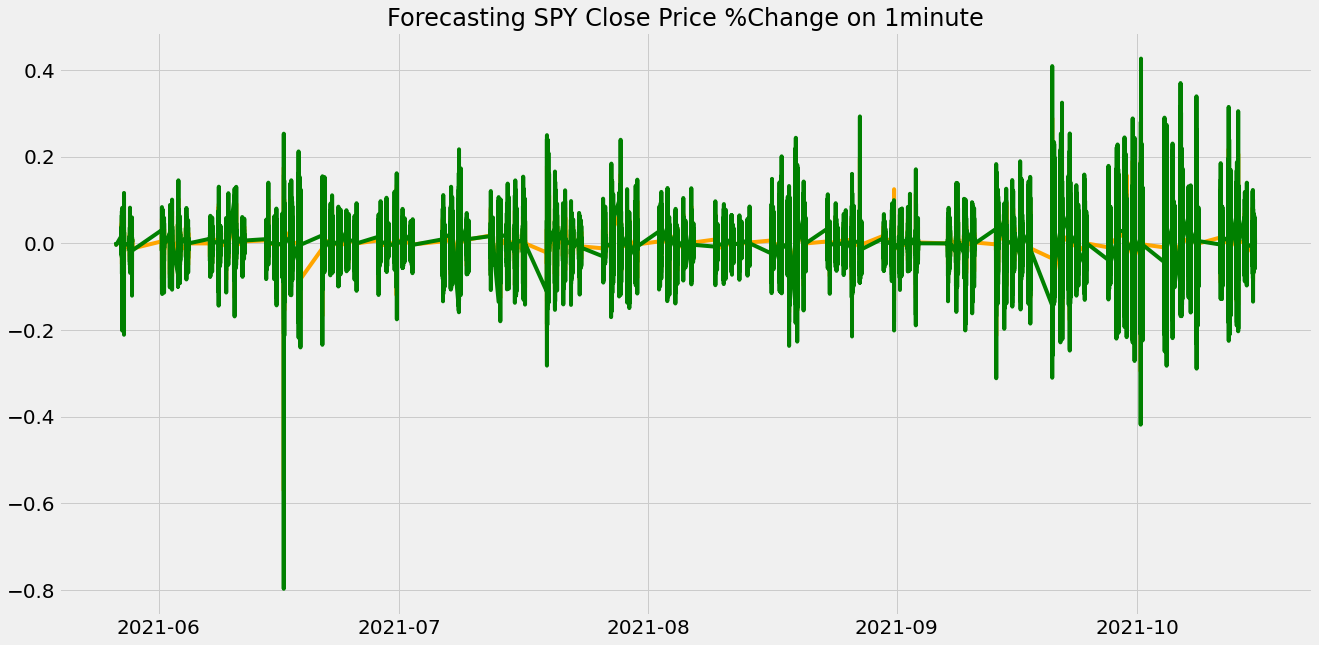

In [14]:
plt.figure(figsize=(20,10))

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green')

# Set label.
plt.title(label = 'Forecasting SPY Close Price %Change on 1minute', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

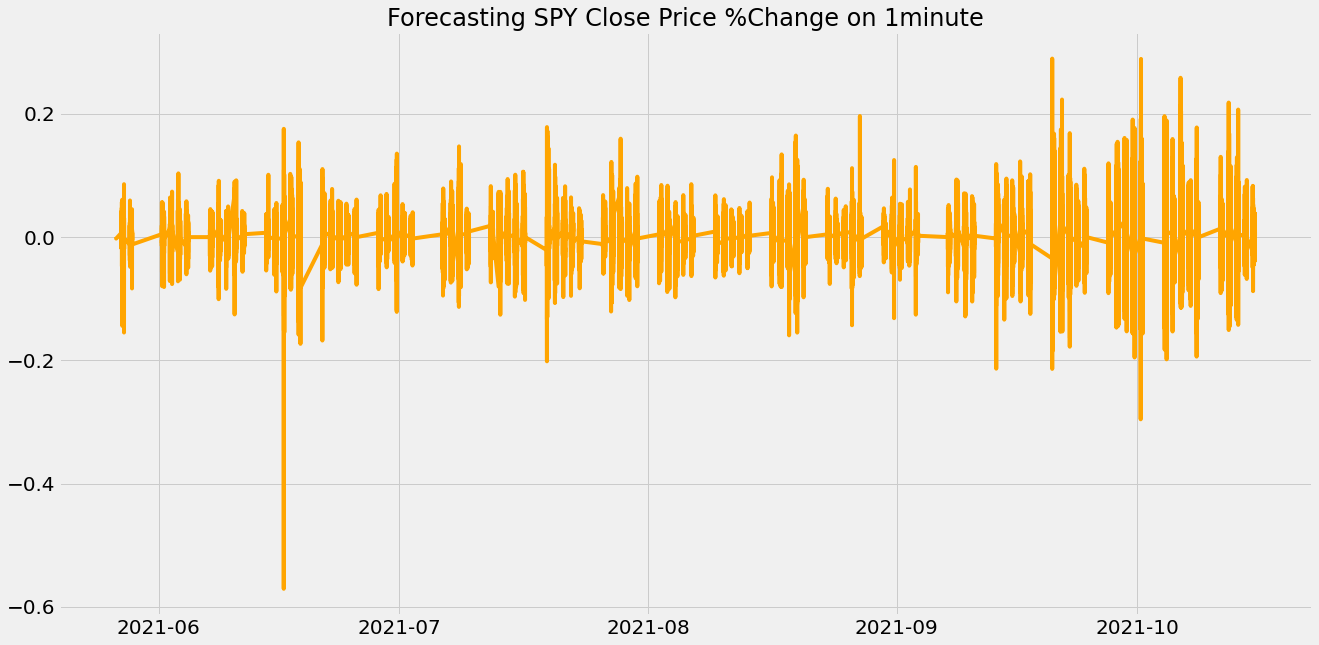

In [15]:
plt.figure(figsize=(20,10))

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Set label.
plt.title(label = 'Forecasting SPY Close Price %Change on 1minute', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [16]:
metrics.r2_score(y_test, lm_results.predict(X_test))

0.7679115736684005

In [17]:
metrics.mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

0.012702576677893557

> **We are seeing a RMSE of 0.0127. This may appear small, but our mean target value is approximately 0 with a standard deviation of 0.05**

# Seasonal AutoRegressive Integrated Moving Average (SARIMAX)

**We want to include Exogenous variables via our Engineered Features, so we will utilize the SARIMAX model.**

In [18]:
print(f'Number of observations: {len(df)}')
print(f'Number of training observations: {round(len(df) * 0.75)}')
print(f'Number of testing observations: {len(df) - round(len(df) * 0.75)}')

Number of observations: 223008
Number of training observations: 167256
Number of testing observations: 55752


In [19]:
train = pd.DataFrame(df['target'].iloc[:167257,])

test = pd.DataFrame(df['target'].iloc[167257:,])

We will conduct a manual gridsearch to optimize our ARIMA model. The code in the following cell was obtained from GA DSI-82 Lesson 9.03 (presented by Hank Bulter).

In [20]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = train.astype(float).dropna(), # endog = y - variable
                         order = (p, 1, q)) # values of p, d, q
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: -339530.8376432521
Attempting to fit ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: -454834.10491588415
Attempting to fit ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: -454834.2796471937
Attempting to fit ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: -454861.62500938604
Attempting to fit ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: -454835.2173832249
Attempting to fit ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: -385799.364841992
Attempting to fit ARIMA(1, 1, 1)
Attempting to fit ARIMA(1, 1, 2)
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
The AIC for ARIMA(2,1,0) is: -405857.96454619797
Attempting to fit ARIMA(2, 1, 1)
Attempting to fit ARIMA(2, 1, 2)
Attempting to fit ARIMA(2, 1, 3)
Attempting to fit ARIMA(2, 1, 4)
Attempting to fit ARIMA(3, 1, 0)
The AIC for ARIMA(3,1,0) is: -416775.45332713897
Attempting to fit ARIMA(3, 1, 1)
Attempting to fit ARIMA(3, 1, 2)
Attempting to fit A

In [43]:
train_values = train['target'].values
train_dates = train.index

test_values = test['target'].values
test_dates = test.index

In [21]:
# Instantiate and fit
sarimax = SARIMAX(endog = train, # endog = y - variable
                  order = (0, 1, 3), # values of p, d, q
                  seasonal_order = (0,0,0,0))

# Fit ARIMA model.
model = sarimax.fit()

In [44]:
test_dates

DatetimeIndex(['2021-04-22 10:51:00', '2021-04-22 10:52:00',
               '2021-04-22 10:53:00', '2021-04-22 10:54:00',
               '2021-04-22 10:55:00', '2021-04-22 10:56:00',
               '2021-04-22 10:57:00', '2021-04-22 10:58:00',
               '2021-04-22 10:59:00', '2021-04-22 11:00:00',
               ...
               '2021-10-15 16:21:00', '2021-10-15 16:22:00',
               '2021-10-15 16:23:00', '2021-10-15 16:24:00',
               '2021-10-15 16:25:00', '2021-10-15 16:26:00',
               '2021-10-15 16:27:00', '2021-10-15 16:28:00',
               '2021-10-15 16:29:00', '2021-10-15 16:30:00'],
              dtype='datetime64[ns]', name='time', length=55751, freq=None)

In [45]:
# Generate predictions based on test set.
# preds = model.forecast(5)
# preds

preds = model.predict(start = test_dates[0], 
                      end = test_dates[-1])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
# Plot predicted test values.
plt.plot(test.index, preds, color = 'green')

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train).diff(), color = 'blue')

# Plot testing data.
plt.plot(test.index, pd.DataFrame(test).diff(), color = 'orange')


plt.title(label = 'Once-Differenced Close Price %Change with SARIMAX(0, 1, 4, 450) Predictions', fontsize=16)
plt.show();